## Data Importing and Pre-processing

In [1]:
# import libraries needed
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.*")
%matplotlib inline

In [2]:
# read file and see number of rows and cols
nba_df = pd.read_csv("nba_2022-23_all_stats_with_salary.csv")
nba_df.shape

(467, 52)

In [3]:
nba_df.head()

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Total Minutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,0.493,4.9,11.4,0.427,5.1,8.8,0.579,0.614,4.6,5.0,0.915,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,1941,24.1,0.656,0.564,0.248,2.3,16.8,9.7,30.0,1.3,0.9,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,0.408,1.0,3.2,0.303,3.1,6.7,0.459,0.457,2.3,3.3,0.681,0.4,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,755,13.6,0.498,0.322,0.334,2.1,11.4,6.8,35.3,1.8,1.4,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,13.6,0.436,1.2,3.9,0.311,4.7,9.7,0.487,0.481,2.8,4.3,0.656,1.2,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,2126,16.1,0.513,0.289,0.317,4.7,16.5,10.8,38.6,1.7,1.3,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,22.2,0.500,2.2,6.9,0.321,8.9,15.3,0.580,0.549,4.6,5.9,0.768,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,1954,23.9,0.583,0.309,0.268,3.7,20.8,12.5,33.5,1.2,1.4,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,18.3,0.560,2.0,4.9,0.404,8.3,13.4,0.617,0.614,6.5,7.1,0.919,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,1672,25.9,0.677,0.267,0.387,1.2,19.5,10.5,24.5,1.0,3.4,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


In [4]:
# full_nba_salaries = pd.read_csv('full_nba_salaries.csv')

# # Define the years and corresponding column names for salaries
# years = ['2017-18', '2018-19', '2019-20', '2020-21']
# salary_columns = [f'Salary{year[2:4]}-{year[5:]}' for year in years]

# # Initialize new salary columns in the nba_stats DataFrame with 0
# for col in salary_columns:
#     nba_df[col] = 0

# # Iterate through the full_nba_salaries DataFrame
# for index, row in full_nba_salaries.iterrows():
#     season = row['Season']
#     player_name = row['Name']
    
#     if season in years:
#         salary_col = f'Salary{season[2:4]}-{season[5:]}'
#         # Update the salary in the nba_stats DataFrame, converting to integer
#         nba_df.loc[nba_df['Player Name'] == player_name, salary_col] = int(row['Salary'].replace('$', '').replace(',', '').replace('(TW)', ''))



# # Display the updated DataFrame
# nba_df

In [5]:
# reanme 'Unnamed: 0' column to 'ID'
nba_df = nba_df.rename(columns={"Unnamed: 0": "Id"})

In [6]:
# Remove spaces from column names
nba_df.columns = [col.replace(" ", "") for col in nba_df.columns]

In [7]:
# count number of categorical variables
category_count = 0

for cat in nba_df.dtypes:
    if cat == "object":
        category_count += 1

In [8]:
print("Number of categorical variables:", category_count)

# column 1 is the ID column so we subract 1
numeric_count = nba_df.shape[1] - category_count - 1

print("Number of contineous variables:", numeric_count)

Number of categorical variables: 3
Number of contineous variables: 48


In [9]:
# see all the column names
nba_df.columns

Index(['Id', 'PlayerName', 'Salary', 'Position', 'Age', 'Team', 'GP', 'GS',
       'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'TotalMinutes', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'],
      dtype='object')

### Handling our missing data

In [10]:
# display the missing data and its percent of the column
total_missing = nba_df.isnull().sum().sort_values(ascending=False)
percent_missing = (nba_df.isnull().sum() / nba_df.isnull().count()).sort_values(ascending=False)

missing_data_df = pd.concat([total_missing, percent_missing], axis=1, keys=["Total Missing", "Percent Missing"])
missing_data_df.head(8)

,Total Missing,Percent Missing
FT%,23,0.049251
3P%,13,0.027837
2P%,4,0.008565
TS%,1,0.002141
3PAr,1,0.002141
FTr,1,0.002141
eFG%,1,0.002141
FG%,1,0.002141


In [11]:
# example row of a player who has missing data
# players with missing data are those who did not play many games so they never accumilated that stat during the season
null_fg = nba_df[nba_df['FG%'].isnull()]
null_fg

,Id,PlayerName,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TotalMinutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
436,436,Alondes Williams,254446,SG,23,BRK,1,0,5.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,5,-20.9,NaN,NaN,NaN,0.0,22.0,11.2,0.0,0.0,0.0,100.0,17.7,-0.1,0.0,-0.1,-0.517,-21.3,-5.2,-26.5,0.0


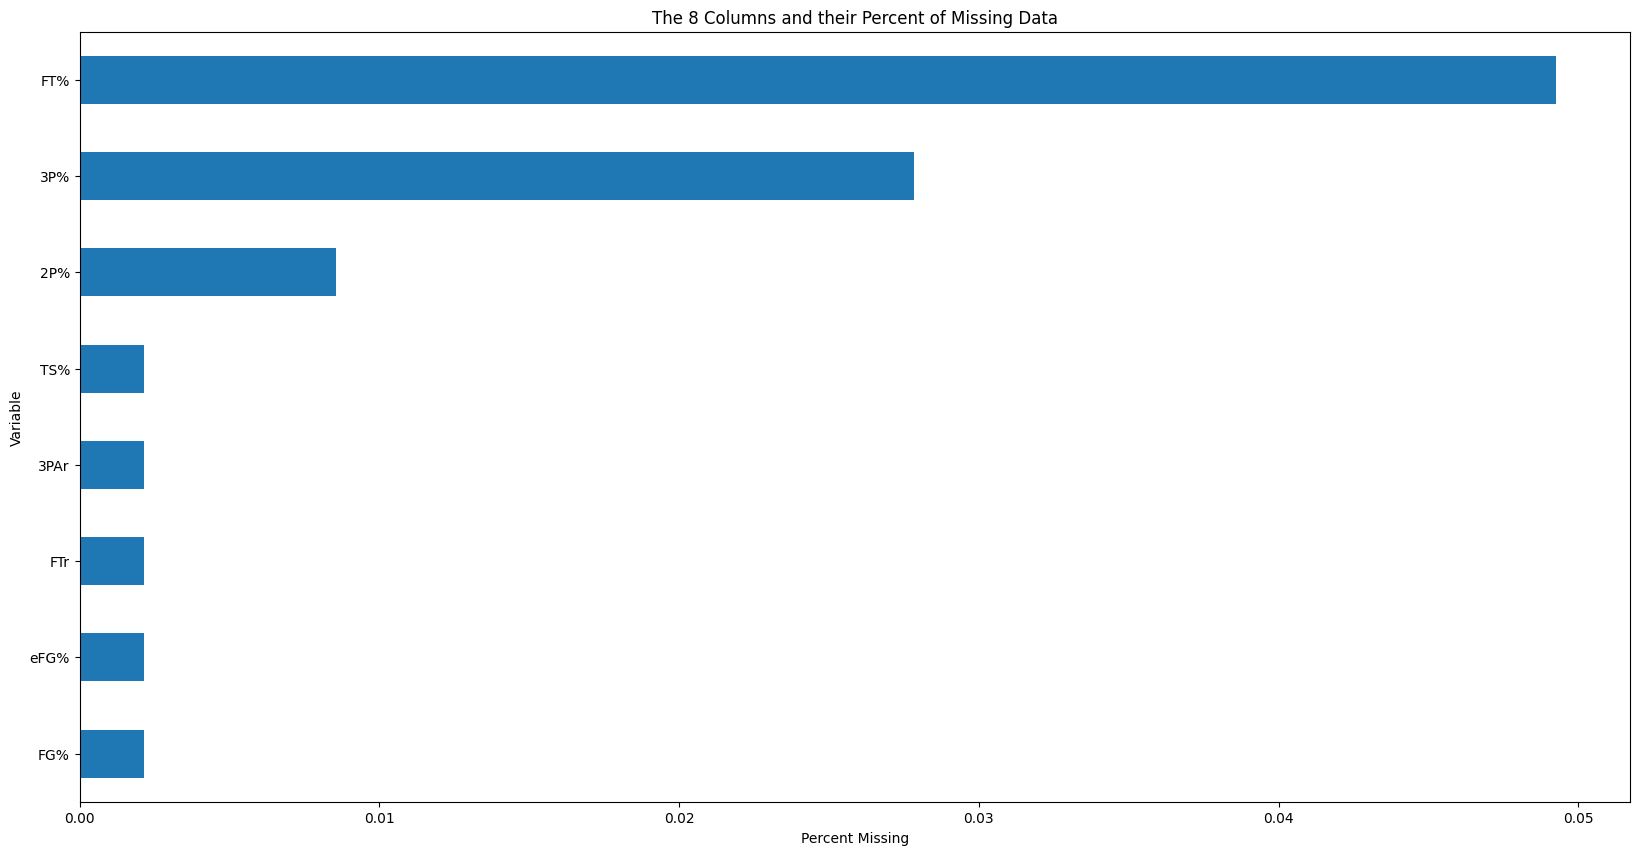

In [12]:
# visualize this in a bar graph
missing_data_df["Percent Missing"].head(8).plot(
    kind="barh", figsize=(20,10)
).invert_yaxis()
plt.xlabel("Percent Missing")
plt.ylabel("Variable")
plt.title("The 8 Columns and their Percent of Missing Data")
plt.show()

In [13]:
# fill in the missing data with 0s
# data is "missing" because player never recorded that stat during the season so we impute that data to be 0 to identify them in our model
cols_to_fill_zero = [
    "FT%",
    "3P%",
    "2P%",
    "TS%",
    "3PAr",
    "FTr",
    "eFG%",
    "FG%",
]

for col in cols_to_fill_zero:
    nba_df[col] = nba_df[col].fillna(0)


In [14]:
# show same player who had null values now has zeros in those fields
imputed_row = nba_df[nba_df["PlayerName"] == "Alondes Williams"]
imputed_row

,Id,PlayerName,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TotalMinutes,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
436,436,Alondes Williams,254446,SG,23,BRK,1,0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,5,-20.9,0.0,0.0,0.0,0.0,22.0,11.2,0.0,0.0,0.0,100.0,17.7,-0.1,0.0,-0.1,-0.517,-21.3,-5.2,-26.5,0.0


### Handling outliers for better training

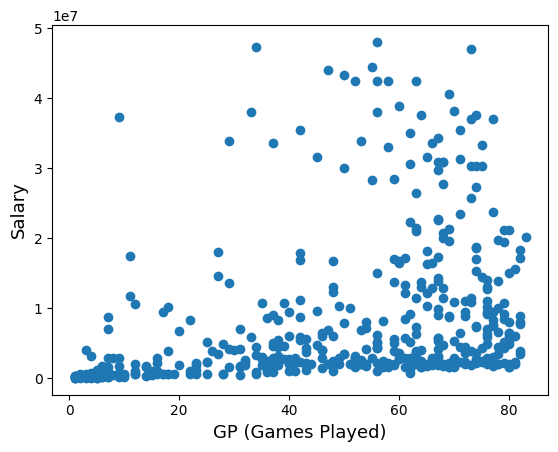

In [15]:
fig, ax = plt.subplots()
ax.scatter(x=nba_df["GP"], y=nba_df["Salary"])
plt.ylabel("Salary", fontsize=13)
plt.xlabel("GP (Games Played)", fontsize=13)
plt.show()

There seem to be some outliers where players did not play the majority of the season, yet were given large salaries. This is likely due to season ending injuries. Additionally, there are players present in the data set that were on 10-day contracts. For this reason, we will remove data from players who played in less than 20 games.

In [16]:
# drop less than 20 games
nba_df = nba_df[nba_df['GP'] >= 20]

### Normalize


 mu = 9990402.62 and sigma = 11134520.23



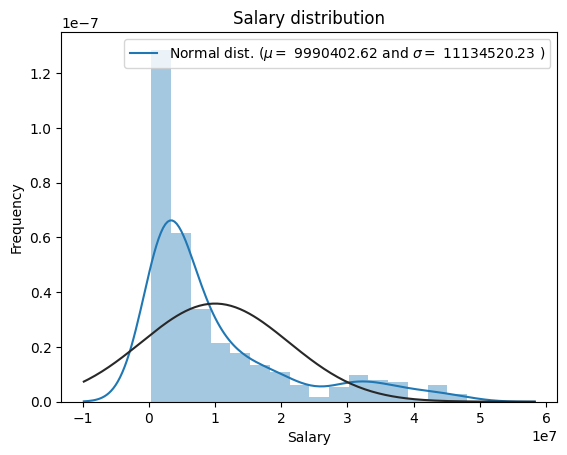

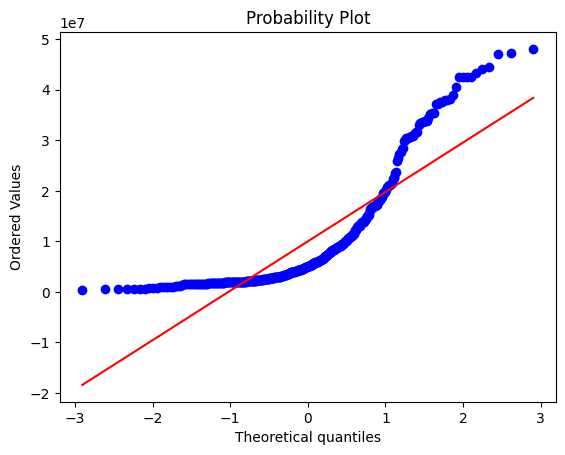

In [17]:
sns.distplot(nba_df["Salary"], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(nba_df["Salary"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(
    ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best"
)
plt.ylabel("Frequency")
plt.title("Salary distribution")

# Get also the QQ-plot
fig = plt.figure()
res = probplot(nba_df["Salary"], plot=plt)
plt.show()


 mu = 15.54 and sigma = 1.09



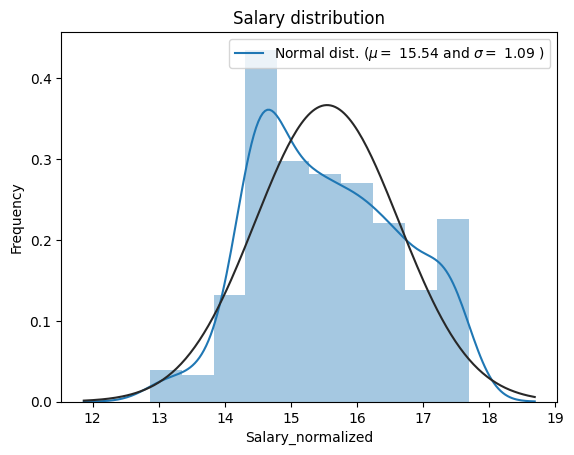

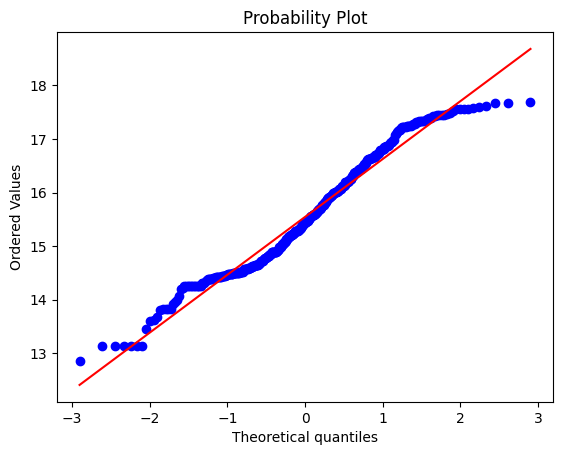

In [18]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
nba_df["Salary_normalized"] = np.log1p(nba_df["Salary"])

# Check the new distribution
sns.distplot(nba_df["Salary_normalized"], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(nba_df["Salary_normalized"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(
    ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)], loc="best"
)
plt.ylabel("Frequency")
plt.title("Salary distribution")

# Get also the QQ-plot
fig = plt.figure()
res = probplot(nba_df["Salary_normalized"], plot=plt)
plt.show()

## Data Analysis and Visualization

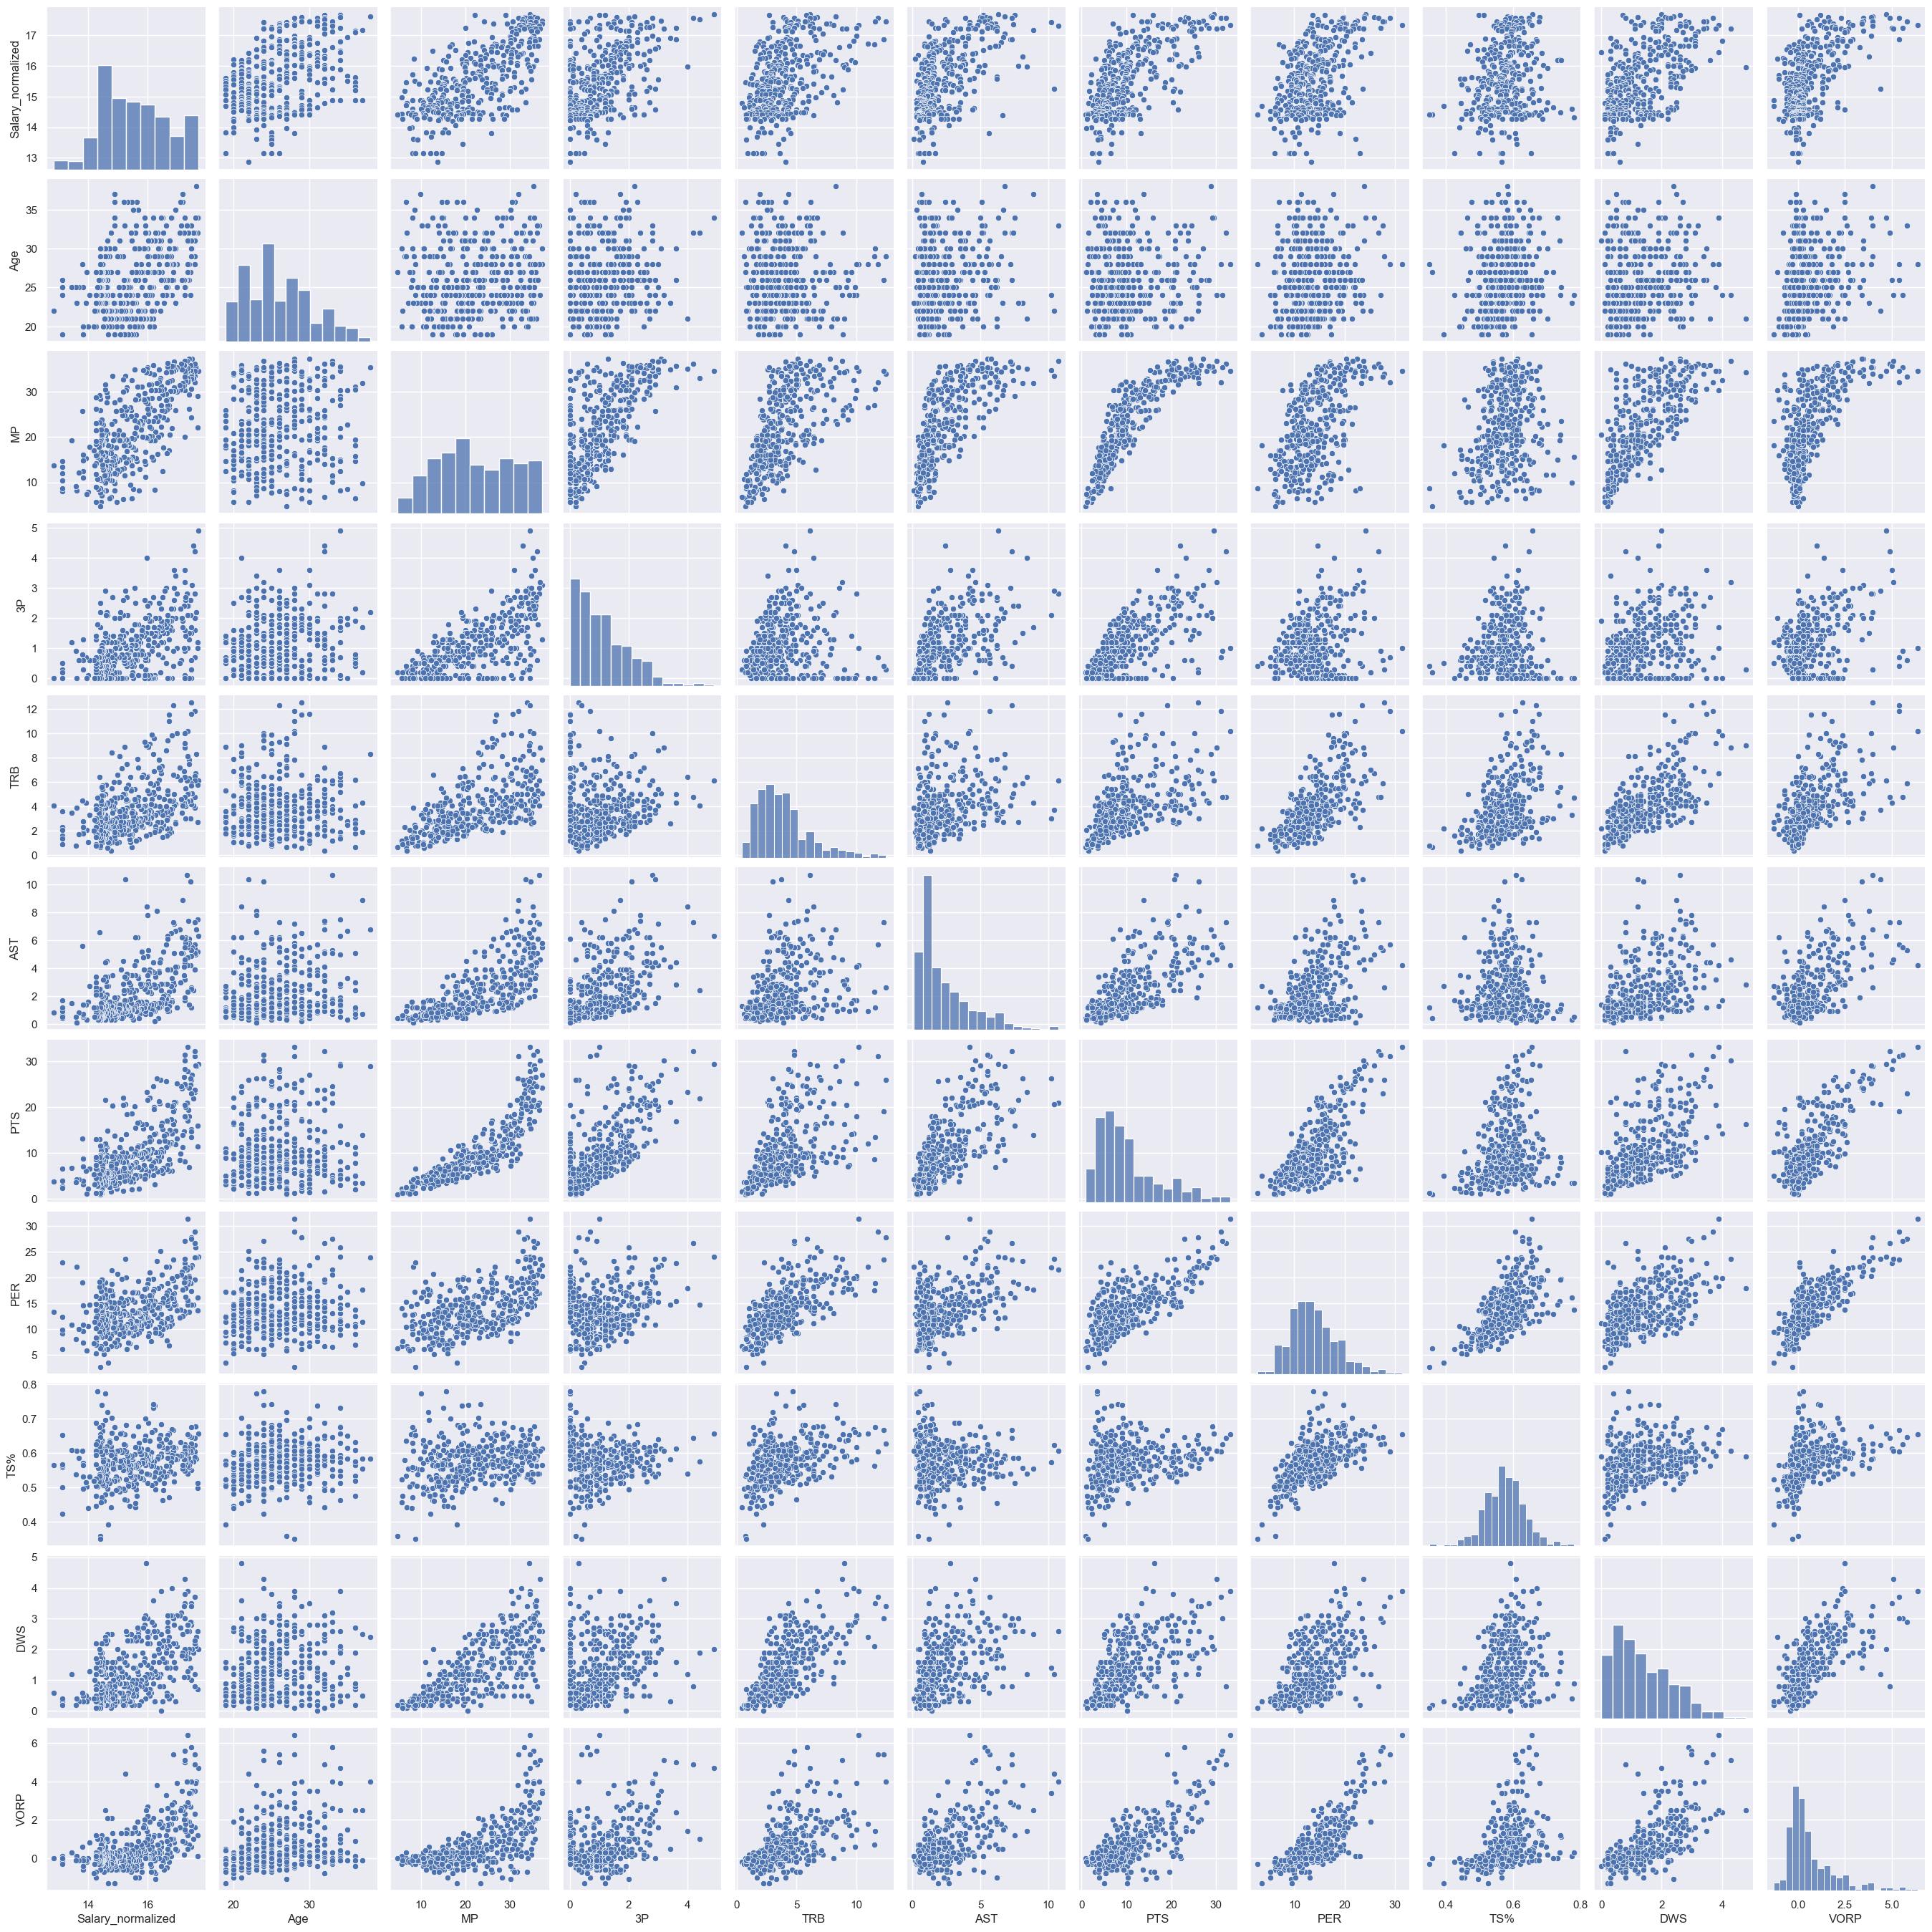

In [19]:
# scatterplot
sns.set()
cols = [
    "Salary_normalized",
    "Age",
    "MP",
    "3P",
    "TRB",
    "AST",
    "PTS",
    "PER",
    "TS%",
    "DWS",
    "VORP"
]
sns.pairplot(nba_df[cols], size=2.5)
plt.show();

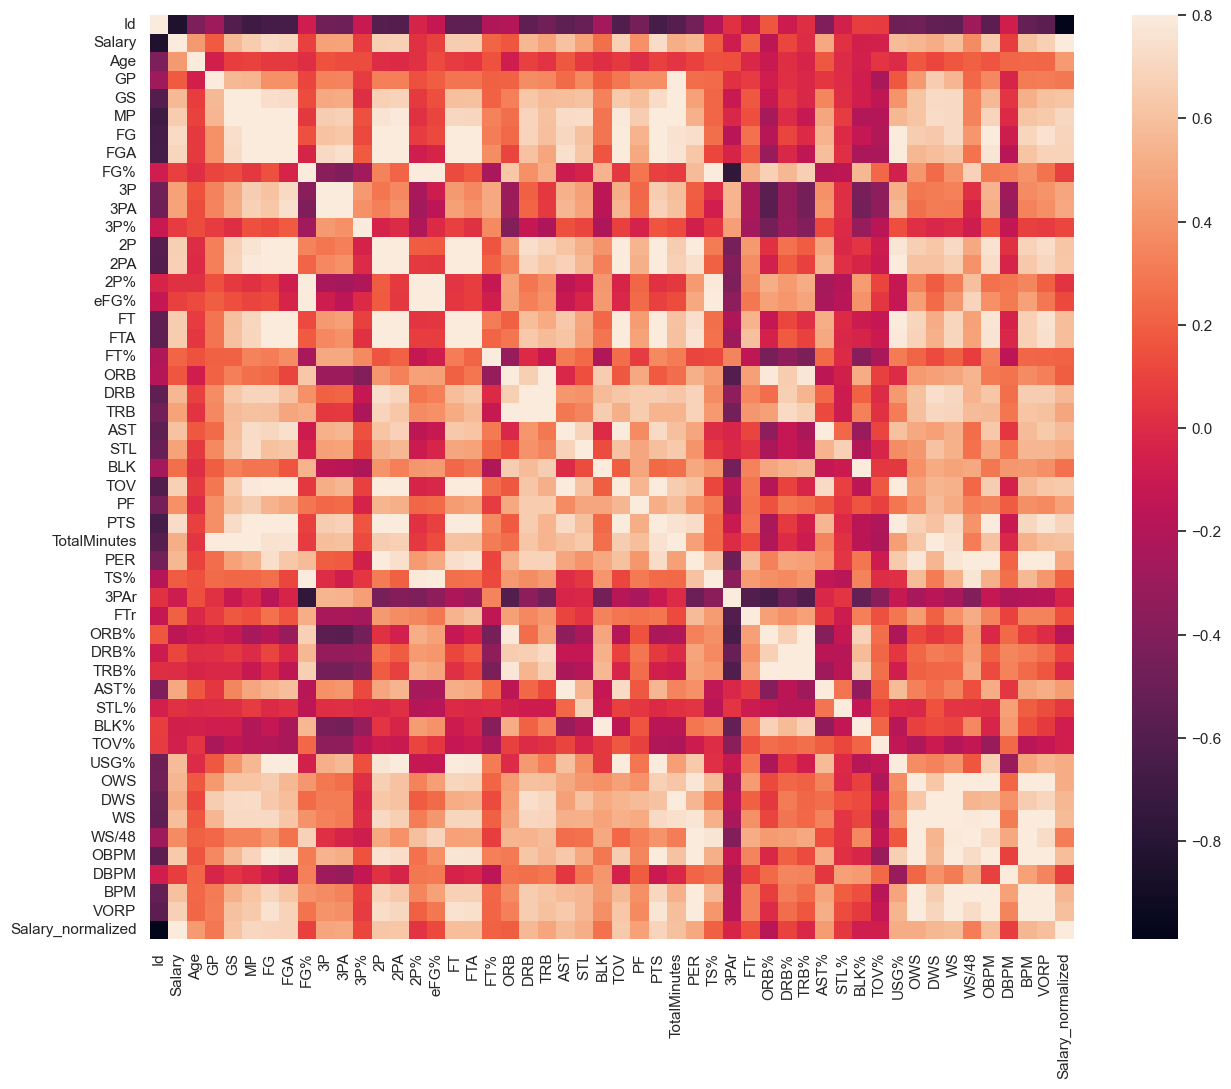

In [20]:
# Exclude non-numeric columns
numeric_df = nba_df.select_dtypes(include=[np.number])
corrmat = numeric_df.corr()

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.8, square=True);

In [21]:
salary_correlations = corrmat['Salary_normalized']
print(salary_correlations.sort_values(ascending=False))

Salary_normalized    1.000000
Salary               0.889315
MP                   0.705716
FG                   0.691265
PTS                  0.689810
FGA                  0.682263
TOV                  0.643688
2PA                  0.627971
2P                   0.618999
GS                   0.617404
TotalMinutes         0.602006
VORP                 0.593305
OBPM                 0.587864
FT                   0.583878
FTA                  0.583573
AST                  0.579333
WS                   0.575457
DRB                  0.564469
DWS                  0.559693
BPM                  0.554775
STL                  0.520078
USG%                 0.512979
OWS                  0.509534
3PA                  0.492245
PER                  0.488896
TRB                  0.485257
3P                   0.483699
PF                   0.457441
AST%                 0.436578
Age                  0.429476
WS/48                0.313509
GP                   0.296261
BLK                  0.267544
FT%       

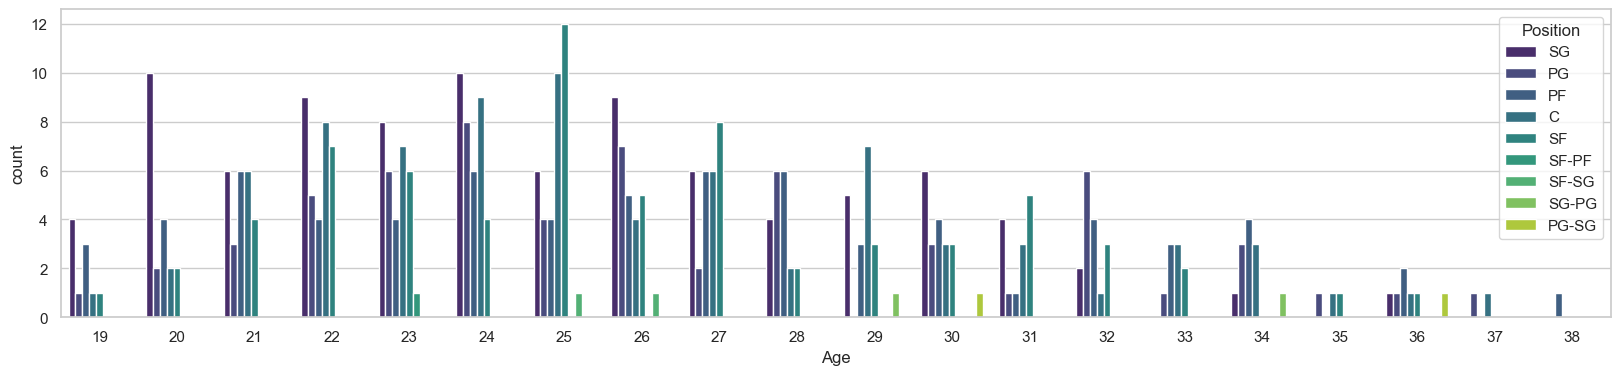

In [22]:
# Visualize number of players at each position by age

plt.figure(figsize=(20,4))
sns.set_style('whitegrid')
sns.countplot(x='Age',hue='Position', data=nba_df, palette='viridis');

#### Target Variable Visualizations

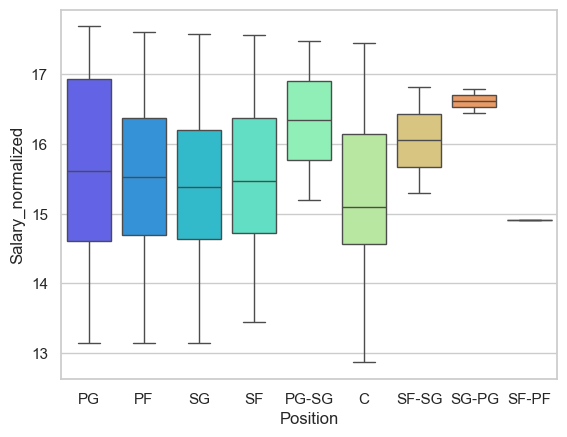

In [23]:
# boxplot to visualize the spread of salaries by each position
sns.boxplot(x='Position', y='Salary_normalized', data=nba_df, palette='rainbow');

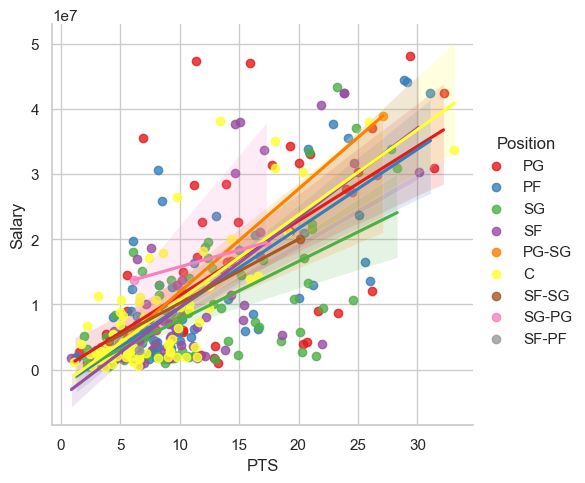

In [24]:
# plot to show correclation between points and salaries by position as well
# points has the highest positive correlation to salary as seen above
sns.lmplot(y='Salary', x='PTS', data=nba_df, hue='Position', palette='Set1');

Now lets compare Salary to VORP.
VORP is a box score estimate of the points per 100 team possessions that a player contributes above a replacement level player, translated to an average team and proportional to an 82 game season.

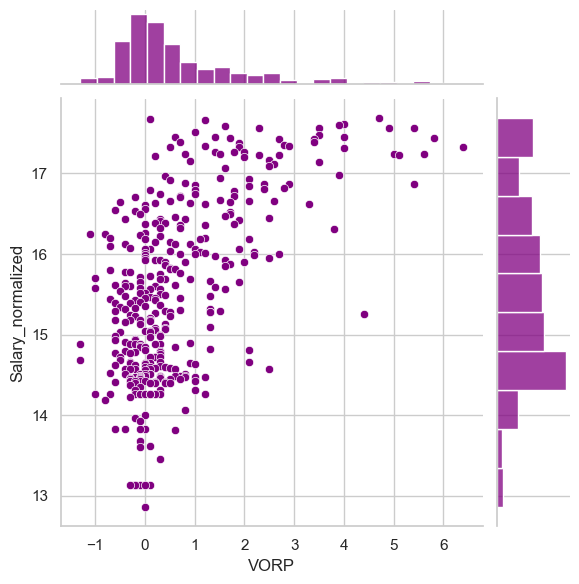

In [25]:
sns.jointplot(x='VORP',y='Salary_normalized',data=nba_df,color='purple');

Now lets compare Salary to a defensive advanced statistic like DWS.
DWS stands for Defensive Win Shares, which is a metric in the NBA that compares a player's defensive rating to the league average.

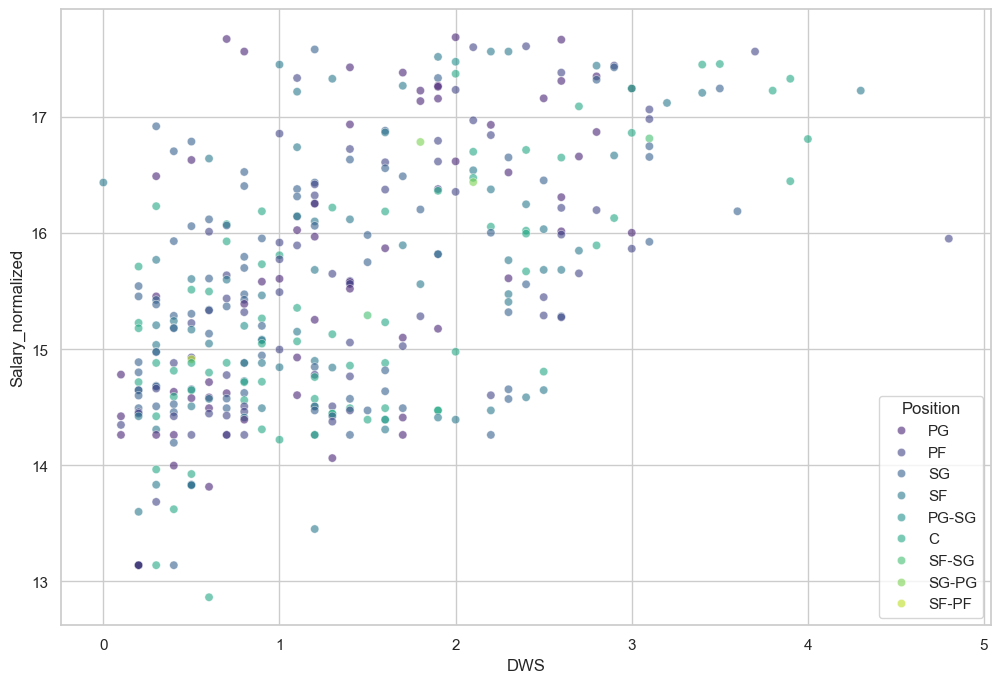

In [26]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='DWS', y='Salary_normalized', data=nba_df, hue='Position', palette='viridis', alpha=0.6);

#### Feature Selection

#### Step 1: Remove Highly Correlated Features
First, we calculate the correlation matrix to identify pairs of features that are highly correlated (correlation coefficient > 0.95). Highly correlated features can introduce multicollinearity, which negatively impacts model performance. We keep only one feature from each pair of highly correlated features to avoid redundancy.

In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# Identify the columns to exclude from feature selection
exclude_columns = ['Id', 'Salary', 'Salary_normalized']

# Get the numerical columns excluding the columns to exclude
numeric_columns = [col for col in numeric_df.columns if col not in exclude_columns]

# # Create a new correlation matrix with only the relevant columns
# corrmat_filtered = corrmat.loc[numeric_columns, numeric_columns]

# # Find highly correlated features
# corr_threshold = 0.95
# correlated_features = set()

# # Get the absolute correlation of each feature with 'Salary_normalized'
# salary_corr = abs(corrmat['Salary'][numeric_columns])

# # Iterate over the features
# for feature in corrmat_filtered.columns:
#     if feature not in correlated_features:
        
#         # Find highly correlated features with the current feature
#         correlated_cols = corrmat_filtered.columns[(abs(corrmat_filtered[feature]) > corr_threshold) & (corrmat_filtered.columns != feature)]
        
#         # append correlated features to be removed
#         correlated_features.update(correlated_cols)
        
# # Drop the correlated features from nba_df
# print("Removing features from nba_df:\n", correlated_features)
# nba_df = nba_df.drop(columns=correlated_features)
# corrmat.drop(columns=correlated_features, inplace=True)
# numeric_df = numeric_df.drop(columns=correlated_features)
# nba_df.head()


In [28]:
low_corr_columns = [col for col in numeric_columns if abs(corrmat.loc[col, 'Salary']) < 0.2]

print(low_corr_columns)

numeric_df.drop(columns=low_corr_columns, inplace=True)

nba_df.drop(columns=low_corr_columns, inplace=True)

['GP', 'FG%', '3P%', '2P%', 'eFG%', 'ORB', 'TS%', '3PAr', 'ORB%', 'DRB%', 'TRB%', 'STL%', 'BLK%', 'TOV%', 'DBPM']


In [29]:
nba_df

,Id,PlayerName,Salary,Position,Age,Team,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,FT%,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TotalMinutes,PER,FTr,AST%,USG%,OWS,DWS,WS,WS/48,OBPM,BPM,VORP,Salary_normalized
0,0,Stephen Curry,48070014,PG,34,GSW,56,34.7,10.0,20.2,4.9,11.4,5.1,8.8,4.6,5.0,0.915,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,1941,24.1,0.248,30.0,31.0,5.8,2.0,7.8,0.192,7.5,7.5,4.7,17.688169
1,1,John Wall,47345760,PG,32,LAC,3,22.2,4.1,9.9,1.0,3.2,3.1,6.7,2.3,3.3,0.681,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,755,13.6,0.334,35.3,27.0,-0.4,0.7,0.3,0.020,-0.8,-1.2,0.1,17.672988
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,24,29.1,5.9,13.6,1.2,3.9,4.7,9.7,2.8,4.3,0.656,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,2126,16.1,0.317,38.6,27.7,-0.6,2.6,1.9,0.044,0.3,0.2,1.2,17.667363
3,3,LeBron James,44474988,PF,38,LAL,54,35.5,11.1,22.2,2.2,6.9,8.9,15.3,4.6,5.9,0.768,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,1954,23.9,0.268,33.5,33.3,3.2,2.4,5.6,0.138,5.5,6.1,4.0,17.610438
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,35.6,10.3,18.3,2.0,4.9,8.3,13.4,6.5,7.1,0.919,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,1672,25.9,0.387,24.5,30.7,4.7,2.1,6.8,0.194,6.0,7.1,3.9,17.602420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,418,Luka Garza,508891,C,24,MIN,0,8.7,2.3,4.1,0.5,1.4,1.8,2.8,1.5,1.9,0.788,1.1,2.3,0.6,0.1,0.1,0.5,1.5,6.5,243,23.0,0.448,11.8,26.9,0.9,0.2,1.1,0.211,2.2,-0.4,0.1,13.139991
419,419,Kevon Harris,508891,SG,25,ORL,0,13.4,1.4,3.1,0.5,1.3,0.9,1.9,0.9,1.2,0.756,1.2,2.1,0.5,0.5,0.1,0.6,1.6,4.1,457,9.2,0.383,4.7,13.7,0.2,0.4,0.6,0.065,-3.5,-3.6,-0.2,13.139991
422,422,Dominick Barlow,508891,PF,19,SAS,0,14.6,1.6,3.1,0.0,0.1,1.6,2.9,0.6,0.9,0.720,2.0,3.6,0.9,0.4,0.7,0.5,2.0,3.9,408,12.4,0.291,7.6,11.3,0.5,0.2,0.7,0.082,-3.7,-4.6,-0.3,13.139991
424,424,Jeff Dowtin,508891,PG,25,TOR,0,10.4,1.0,2.3,0.2,0.6,0.8,1.6,0.2,0.4,0.667,0.7,0.9,1.2,0.4,0.1,0.2,0.5,2.4,259,9.9,0.158,15.5,10.9,0.2,0.2,0.4,0.076,-2.8,-1.9,0.0,13.139991


#### Step 2: Encoding Categorical Features
Next, we will encode categorical features so that our supervised model can use them for predicitons. These features are Position and Team. The position and team are likely influential on a player's salary but are represented by strings in our dataset. We will label encoding because the values of these features are within a limited range. This will give each team and position a unique numerical marker.

In [30]:
from sklearn.preprocessing import LabelEncoder

# Create label encoders
position_encoder = LabelEncoder()
team_encoder = LabelEncoder()

# Perform label encoding for 'Position' and 'Team' variables
nba_df['Position_encoded'] = position_encoder.fit_transform(nba_df['Position'])
nba_df['Team_encoded'] = team_encoder.fit_transform(nba_df['Team'])

# Drop the original 'Position' and 'Team' columns
nba_df.drop(['Position', 'Team'], axis=1, inplace=True)
nba_df.head()


,Id,PlayerName,Salary,Age,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,FT%,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TotalMinutes,PER,FTr,AST%,USG%,OWS,DWS,WS,WS/48,OBPM,BPM,VORP,Salary_normalized,Position_encoded,Team_encoded
0,0,Stephen Curry,48070014,34,56,34.7,10.0,20.2,4.9,11.4,5.1,8.8,4.6,5.0,0.915,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,1941,24.1,0.248,30.0,31.0,5.8,2.0,7.8,0.192,7.5,7.5,4.7,17.688169,2,22
1,1,John Wall,47345760,32,3,22.2,4.1,9.9,1.0,3.2,3.1,6.7,2.3,3.3,0.681,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,755,13.6,0.334,35.3,27.0,-0.4,0.7,0.3,0.020,-0.8,-1.2,0.1,17.672988,2,29
2,2,Russell Westbrook,47080179,34,24,29.1,5.9,13.6,1.2,3.9,4.7,9.7,2.8,4.3,0.656,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,2126,16.1,0.317,38.6,27.7,-0.6,2.6,1.9,0.044,0.3,0.2,1.2,17.667363,2,34
3,3,LeBron James,44474988,38,54,35.5,11.1,22.2,2.2,6.9,8.9,15.3,4.6,5.9,0.768,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,1954,23.9,0.268,33.5,33.3,3.2,2.4,5.6,0.138,5.5,6.1,4.0,17.610438,1,32
4,4,Kevin Durant,44119845,34,47,35.6,10.3,18.3,2.0,4.9,8.3,13.4,6.5,7.1,0.919,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,1672,25.9,0.387,24.5,30.7,4.7,2.1,6.8,0.194,6.0,7.1,3.9,17.602420,1,6


In [31]:
# identify skewness
skewed_feats = (
    numeric_df
    .apply(lambda x: skew(x.dropna()))
    .sort_values(ascending=False)
)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({"Skew": skewed_feats})
skewness.head(20)


Skew in numerical features: 



,Skew
BLK,2.220945
FT,2.082965
FTA,2.023634
VORP,1.788223
Salary,1.621728
AST,1.488839
OWS,1.450663
2P,1.312279
TRB,1.262540
2PA,1.252502


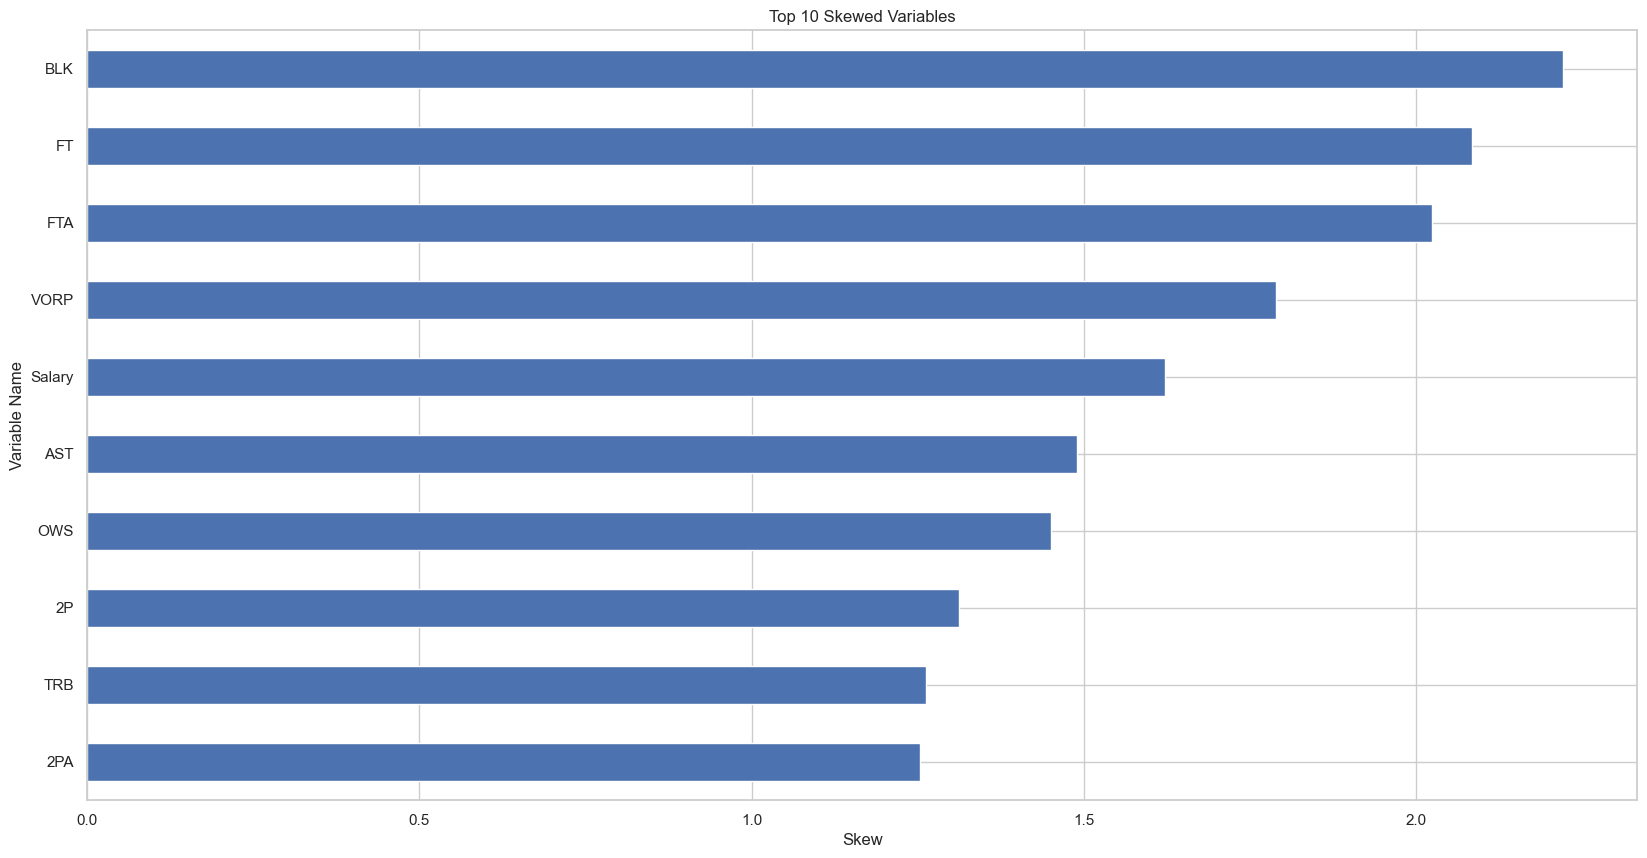

In [32]:
skewness["Skew"].head(10).plot(
    kind="barh", figsize=(20, 10)
).invert_yaxis()  # top 10 skewed columns
plt.xlabel("Skew")
plt.ylabel("Variable Name")
plt.title("Top 10 Skewed Variables")
plt.show()

In [33]:
skewness = skewness[abs(skewness) > 0.75]
print(
    "There are {} skewed numerical features to Box Cox transform (normalize)".format(
        skewness.shape[0]
    )
)

There are 35 skewed numerical features to Box Cox transform (normalize)


In [34]:
negative_value_columns = numeric_df.columns[(numeric_df < 0).any()]

# Print the list of column names
print("Columns with negative values:")
print(negative_value_columns.tolist())


Columns with negative values:
['OWS', 'WS', 'WS/48', 'OBPM', 'BPM', 'VORP']


In [35]:
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    # skip over columns that don't need transformation
    # skip over columns that have negative values so that they don't become NULL when transforming
    if feat not in [
        "Id",
        "Salary",
        "Salary_normalized",
        "Salary17-18",
        "Salary18-19",
        "Salary19-20",
        "Salary20-21",
        "Salary21-22",
        'OWS', 
        'WS', 
        'WS/48', 
        'OBPM', 
        'DBPM', 
        'BPM', 
        'VORP'
    ]:
        nba_df[feat] = boxcox1p(nba_df[feat], lam)

In [36]:
# check that the box cot did not add any NULL values
null_columns = nba_df.columns[nba_df.isnull().any()]
null_count = nba_df[null_columns].isnull().sum()

print("Column Name: NULL Count")
for i in range(0, len(null_columns)):
    print(f"{null_columns[i]}: {null_count[i]}")

Column Name: NULL Count


## Data Analytics

All of our data is labled therefore we will be implementing supervised learning methods

In [37]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from skopt import BayesSearchCV

In [38]:
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.1)
rf = RandomForestRegressor(n_estimators=500)
dt = DecisionTreeRegressor(max_depth=10)
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)
model_xgb_hyper = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [39]:
def hyperparameter_tune_bayesian(X_train, y_train, regressor):
    """
    Perform hyperparameter tuning for XGBoost using Bayesian search.

    Parameters:
    - X_train: pandas DataFrame
        Training features.
    - y_train: pandas Series
        Training target variable.
    - regressor_type: str
        Type of regressor to tune ('xgboost').

    Returns:
    - best_params: dict
        Best hyperparameters found during tuning.
    """
    # Define the common parameter space for both XGBoost
    param_space_common = {
        "n_estimators": (100, 1200),
        "learning_rate": (0.01, 0.2, "log-uniform"),
        "max_depth": (3, 10),
    }

    regressor_type = regressor.lower()
    if regressor_type == "xgboost":
        regressor = xgb.XGBRegressor()
    else:
        raise ValueError("Unsupported regressor type. Choose 'xgboost'.")

    # Update the search space with common parameters
    param_space = param_space_common.copy()

    # Perform Bayesian search
    bayes_search = BayesSearchCV(
        estimator=regressor,
        search_spaces=param_space,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1,  # Set the number of parallel jobs
    )
    bayes_search.fit(X_train, np.log1p(y_train))

    # Get the best hyperparameters
    best_params = bayes_search.best_params_

    return best_params

In [40]:
def k_fold_regression(
    data,
    regressor,
    target_column="Salary",
    cols_to_ignore=['Salary', 'Id', 'PlayerName', 'Salary_normalized'],
    n_splits=5,
    tune_hyperparameters=False,
    model_name=None
):
    rmse_scores = []
    train_sizes = []
    test_sizes = []
    fold_results = []

    # Prepare the feature matrix X and target vector y
    X = data.drop(columns=cols_to_ignore)
    y = data[target_column]

    # Initialize KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True)

    # Cross-validation process
    foldCount = 0
    fold_models = []
    for train_index, val_index in kf.split(X):
        if (
            isinstance(regressor, (xgb.XGBRegressor))
            and tune_hyperparameters
        ):
            if isinstance(regressor, xgb.XGBRegressor):
                regressor_type = "xgboost"
            else:
                raise ValueError(
                    "Unsupported regressor type. Supported types: XGBRegressor"
                )

            # Use the entire training data for hyperparameter tuning
            best_params = hyperparameter_tune_bayesian(X, y, regressor_type)
            print(f"Best hyperparameters for {regressor_type} Fold: {best_params}")
            regressor.set_params(**best_params)

        # Split into training and validation folds
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Fit the model on the training fold
        regressor.fit(X_train_fold, np.log1p(y_train_fold))  # Fit on log-transformed target
        fold_models.append(regressor)
        y_pred_log_fold = regressor.predict(X_val_fold)
        y_pred_fold = np.expm1(y_pred_log_fold)  # Convert back to original scale

        # Calculate RMSE for the validation fold
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))

        if (
            isinstance(regressor, (xgb.XGBRegressor))
            and tune_hyperparameters
        ):
            print(model_name, f"RMSE: {rmse:.4f}, Train Size: {len(y_train_fold)}, Test Size: {len(y_val_fold)}")

        # if regular xgboost, then print rmse for best folds since this is a high performing model
        elif isinstance(regressor, RandomForestRegressor):
            print(f"Random Forest: {rmse:.4f}, Train Size: {len(y_train_fold)}, Test Size: {len(y_val_fold)}")

        rmse_scores.append(rmse)
        train_sizes.append(len(y_train_fold))
        test_sizes.append(len(y_val_fold))

        # Record results for 'Id', 'Actual', 'Predicted', 'Fold', and 'Set' in a list
        fold_results.append({
            'Id' : foldCount,
            'Actual': y_val_fold.tolist(),
            'Predicted': y_pred_fold,
            'rmse' : rmse
        })
        foldCount += 1

        
    # Create a DataFrame from the results
    result_df = pd.DataFrame(
        fold_results, columns=["Id", "Actual", "Predicted", 'rmse']
    )

    return result_df, rmse_scores, train_sizes, test_sizes, fold_models

    

In [41]:
def compute_rmse_std_k_fold(df, model, tune_hyper=False, model_name=None):
    rmse_list = []
        
    rmse_list.append(k_fold_regression(df, model, tune_hyperparameters=tune_hyper, model_name=model_name)[1])

    mean = np.mean(rmse_list)
    std = np.std(rmse_list)

    return mean, std

In [42]:
#Get the avg rmse and std over 30 tests for each model
lr_no_int_list = compute_rmse_std_k_fold(nba_df, lr_no_int)
lr_w_int_list = compute_rmse_std_k_fold(nba_df, lr_w_int)
elastic_net_list = compute_rmse_std_k_fold(nba_df, elastic_net)
dt_list = compute_rmse_std_k_fold(nba_df, dt)
rf_list = compute_rmse_std_k_fold(nba_df, rf)
model_xgb_list = compute_rmse_std_k_fold(nba_df, model_xgb)

#The next line takes a while (Roughly 10 mins), If want to quickly run, comment out this line and the line below in data
# model_xgb_hyper_list = compute_rmse_std_k_fold(nba_df, model_xgb, tune_hyper=True)

# plot RMSE and STD for each Algorithm
data = {
    "Linear (No Intercept)": lr_no_int_list,
    "Linear (w/ Intercept)": lr_w_int_list,
    "Elastic Net": elastic_net_list,
    "Decision Tree": dt_list,
    "Random Forest": rf_list,
    "XGBoost": model_xgb_list,

    #Comment below if want to run quicker
    # "XGBoost Hyper": model_xgb_hyper_list,
}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by=[0], ascending=True)
data_df.columns = ["Algorithm", "RMSE", "STD"]

Random Forest: 5288598.8125, Train Size: 300, Test Size: 76
Random Forest: 7324380.3518, Train Size: 301, Test Size: 75
Random Forest: 5610554.8335, Train Size: 301, Test Size: 75
Random Forest: 5034095.0174, Train Size: 301, Test Size: 75
Random Forest: 7653000.2941, Train Size: 301, Test Size: 75


In [43]:
data_df

,Algorithm,RMSE,STD
5,XGBoost,5.959497e+06,8.991047e+05
4,Random Forest,6.182126e+06,1.087316e+06
2,Elastic Net,6.812473e+06,6.592510e+05
0,Linear (No Intercept),6.849782e+06,1.246680e+06
1,Linear (w/ Intercept),6.987116e+06,1.132394e+06
3,Decision Tree,7.572894e+06,1.296185e+06


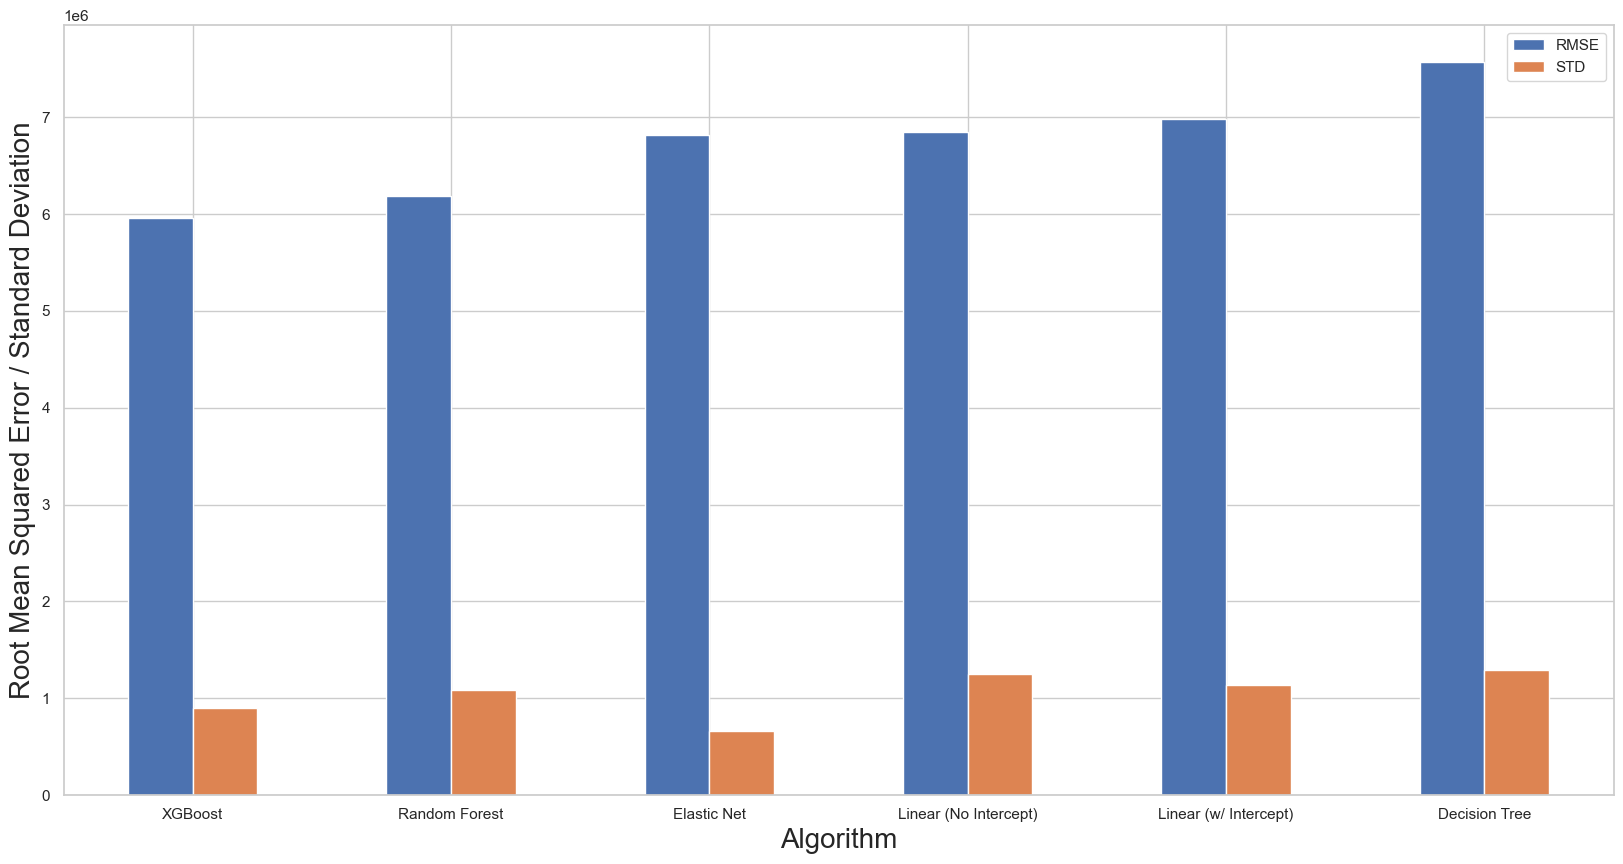

In [44]:
# creating the bar plot
data_df.plot(kind="bar", x="Algorithm", y=["RMSE", "STD"], figsize=(20, 10), rot=0)
plt.xlabel("Algorithm", fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation", fontsize=20)
plt.show()

Hyper tuning XGBoost did not outperform our regular XGBoost model. Therefore, we will not be using it in our stacked or voting models going forward.

### Meta Model

In [45]:
from sklearn.ensemble import StackingRegressor

# first stacking model
  
estimators = [
   ('decision_tree', dt),
   ('rf', rf),
]


sr = StackingRegressor(
   estimators=estimators,
   final_estimator=model_xgb
)

In [46]:
from sklearn.ensemble import VotingRegressor

# voting stacking model, putting weights on different models

vr = VotingRegressor([
   ('rf', rf),
   ('model_xgb', model_xgb),
   ('decision_tree', dt),
  
], weights=[1,1,3])


In [47]:
estimators2 = [
   ('rf', rf),
   ('model_xgb', model_xgb),
   #('decision_tree', dt)
]

# using the voting model as our final estimator

sr2 = StackingRegressor(
   estimators=estimators2,
   final_estimator=vr
)

# More tesing with the new models
Removed Nearest Neighbor, Linear No Int, Linear W Int, Elastic Net, and Descision tree because they are worst performing

In [48]:
rf_list = compute_rmse_std_k_fold(nba_df, rf)
model_xgb_list = compute_rmse_std_k_fold(nba_df, model_xgb)
dt_list = compute_rmse_std_k_fold(nba_df, dt)

sr_list = compute_rmse_std_k_fold(nba_df, sr)
vr_list = compute_rmse_std_k_fold(nba_df, vr)
sr2_list = compute_rmse_std_k_fold(nba_df, sr2)

#model_xgb_hyper_list = compute_rmse_std_k_fold(nba_df, model_xgb, tune_hyper=True)

# plot RMSE and STD for each Algorithm
data = {
    "Random Forest": rf_list,
    "XGBoost": model_xgb_list,
    "Decision Tree": dt_list,
    
    "Stacking Regressor": sr_list,
    "Voting Regressor": vr_list,
    "Stacking Regressor 2": sr2_list,
    
    #"XGBoost Hyper": model_xgb_hyper_list,
}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by=[0], ascending=True)
data_df.columns = ["Algorithm", "RMSE", "STD"]

Random Forest: 7715587.8595, Train Size: 300, Test Size: 76
Random Forest: 5081325.1756, Train Size: 301, Test Size: 75
Random Forest: 7346639.9543, Train Size: 301, Test Size: 75
Random Forest: 4216338.5545, Train Size: 301, Test Size: 75
Random Forest: 6056811.9161, Train Size: 301, Test Size: 75


In [49]:
data_df

,Algorithm,RMSE,STD
0,Random Forest,6.083341e+06,1.322920e+06
1,XGBoost,6.195136e+06,4.855743e+05
4,Voting Regressor,6.763263e+06,1.039117e+06
2,Decision Tree,7.754176e+06,1.189405e+06
3,Stacking Regressor,1.079096e+07,2.406494e+06
5,Stacking Regressor 2,1.121151e+07,8.765097e+05


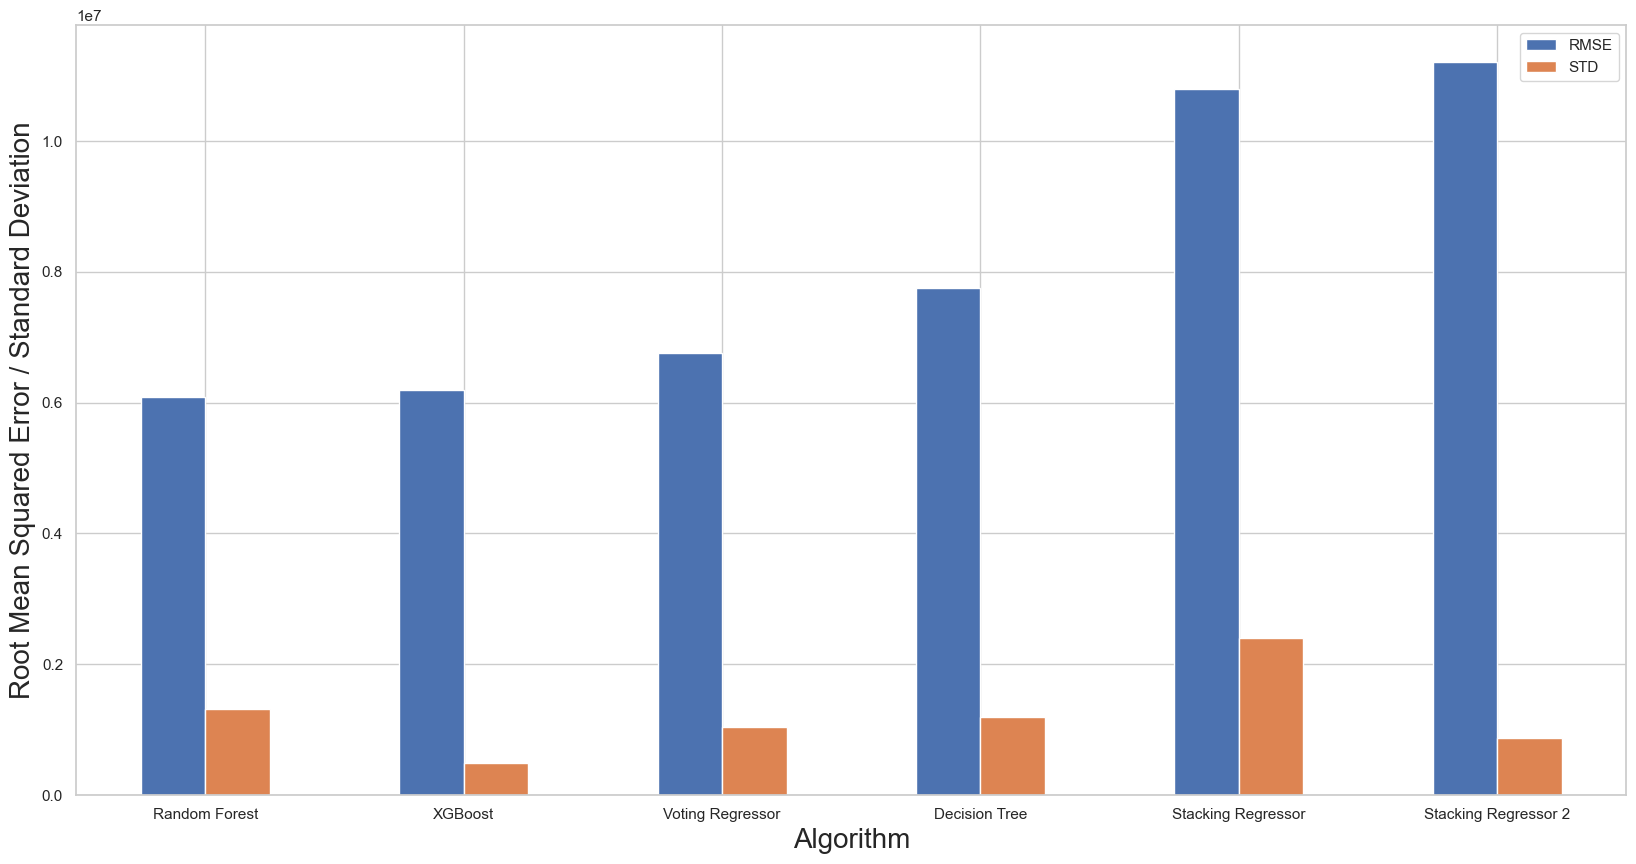

In [50]:
# creating the bar plot
data_df.plot(kind="bar", x="Algorithm", y=["RMSE", "STD"], figsize=(20, 10), rot=0)
plt.xlabel("Algorithm", fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation", fontsize=20)
plt.show()

Looks like Random Forest is still our best performing model

Let's grab the lowest rmse fold

In [51]:
rf_list = k_fold_regression(nba_df, rf, model_name="Random Forest")
rf_preds = rf_list[0]
rf_models = rf_list[4]  # Get the trained models from the returned tuple

rf_preds.head()

Random Forest: 5009162.2728, Train Size: 300, Test Size: 76
Random Forest: 5382279.7526, Train Size: 301, Test Size: 75
Random Forest: 5235922.2041, Train Size: 301, Test Size: 75
Random Forest: 8645788.2022, Train Size: 301, Test Size: 75
Random Forest: 5908478.8778, Train Size: 301, Test Size: 75


,Id,Actual,Predicted,rmse
0,0,"[47080179, 42492492, 42492492, 37980720, 35448...","[22080637.16468182, 29512780.356677882, 352452...",5.009162e+06
1,1,"[42492492, 42492492, 37984276, 30556968, 22600...","[33997998.33334485, 36286600.41329789, 1999883...",5.382280e+06
2,2,"[44474988, 44119845, 38917057, 31650600, 31377...","[41011263.67056458, 39226625.33270941, 3300061...",5.235922e+06
3,3,"[47345760, 43279250, 40600080, 38172414, 37653...","[9503069.531335818, 33294759.807846237, 195673...",8.645788e+06
4,4,"[48070014, 37633050, 37096500, 35448672, 35096...","[40136345.09491288, 18917194.36364126, 2704663...",5.908479e+06


In [ ]:
# Get the feature names
feature_names = nba_df.columns.drop(['Salary', 'Id', 'PlayerName', 'Salary_normalized'])

# Create subplots for each fold
num_folds = 1
fig, axes = plt.subplots(num_folds, 1, figsize=(10, 6 * num_folds))

model = rf_models[0]
feature_importances = model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

ax.bar(range(len(feature_importances)), feature_importances[sorted_indices])
ax.set_xticks(range(len(feature_importances)))
ax.set_xticklabels(feature_names[sorted_indices], rotation=90)
ax.set_xlabel("Features")
ax.set_ylabel("Importance")
ax.set_title(f"Variable Importance - Random Forest")

plt.tight_layout()
plt.show()

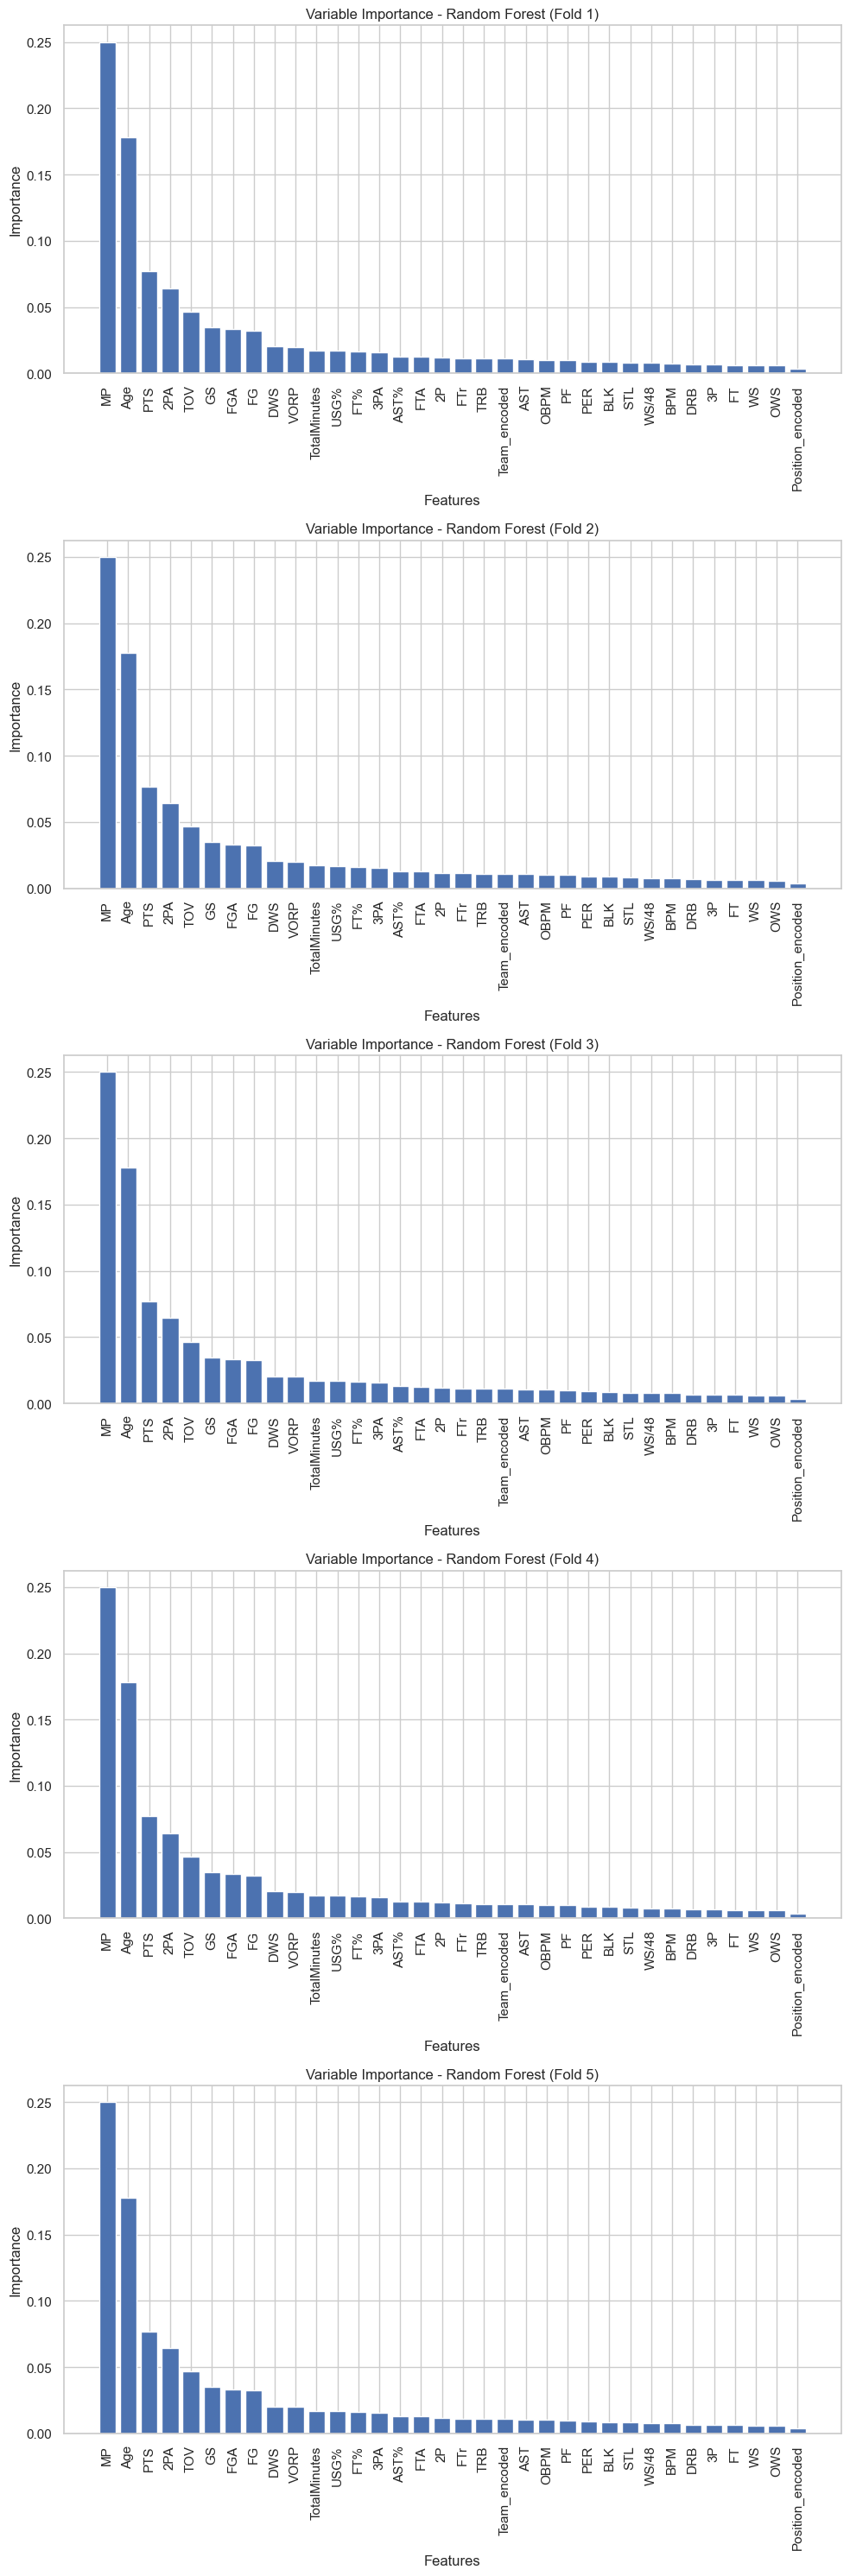

In [62]:
# Get the feature names
feature_names = nba_df.columns.drop(['Salary', 'Id', 'PlayerName', 'Salary_normalized'])

# Create subplots for each fold
num_folds = len(rf_models)
fig, axes = plt.subplots(num_folds, 1, figsize=(10, 6 * num_folds))

# Iterate over each fold and plot the variable importance
for i, (model, ax) in enumerate(zip(rf_models, axes), 1):
    feature_importances = model.feature_importances_
    sorted_indices = feature_importances.argsort()[::-1]
    
    ax.bar(range(len(feature_importances)), feature_importances[sorted_indices])
    ax.set_xticks(range(len(feature_importances)))
    ax.set_xticklabels(feature_names[sorted_indices], rotation=90)
    ax.set_xlabel("Features")
    ax.set_ylabel("Importance")
    ax.set_title(f"Variable Importance - Random Forest (Fold {i})")

plt.tight_layout()
plt.show()

In [53]:
# Sort the DataFrame by the 'rmse' column in ascending order
sorted_df = rf_preds.sort_values(by='rmse', ascending=True)

# Grab the first row of the sorted DataFrame
first_row = sorted_df.iloc[0]

In [54]:
print(first_row[["Actual", "Predicted"]])

Actual       [47080179, 42492492, 42492492, 37980720, 35448...
Predicted    [22080637.16468182, 29512780.356677882, 352452...
Name: 0, dtype: object


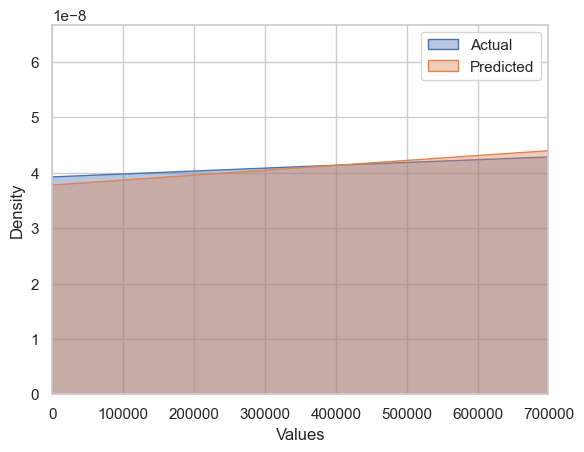

In [55]:
# Assuming first_row is the output from the previous steps
actual_values = first_row["Actual"]
predicted_values = first_row["Predicted"]

# Plot the density plots for Actual and Predicted values
sns.kdeplot(
    data=actual_values,
    fill=True,
    common_norm=False,
    alpha=0.4,
    label="Actual"
)
sns.kdeplot(
    data=predicted_values,
    fill=True,
    common_norm=False,
    alpha=0.4,
    label="Predicted"
)

# Add labels and legend
plt.xlabel("Values")
plt.ylabel("Density")
plt.xlim((0, 700000))
plt.legend()
plt.show()

In [56]:
# Calculate the absolute difference and create a new column
first_row['Difference'] = first_row['Actual'] - first_row['Predicted']

In [57]:
# sanity check on predictions
print("min prediction: ", first_row["Predicted"].min())
print("max prediction: ", first_row["Predicted"].max())
print("max error: ", first_row["Difference"].max())
print("mean error: ", abs(first_row["Difference"]).mean())
print("median error: ", np.median(abs(first_row["Difference"])))

min prediction:  1529058.8437837851
max prediction:  35245260.05989271
max error:  24999541.83531818
mean error:  3317255.2518013404
median error:  1973019.7090764092


<Axes: >

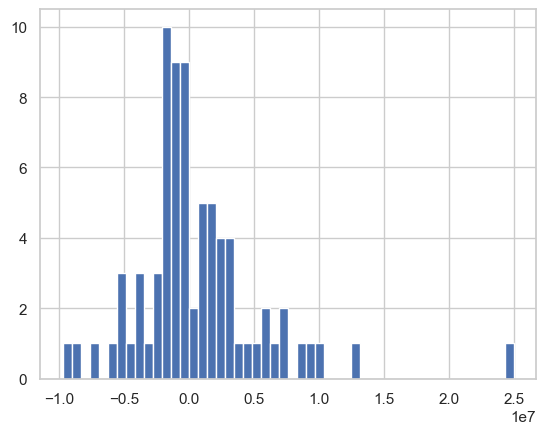

In [58]:
bestdiffs = pd.Series(first_row['Difference'])
# plot a histogram of the difference of our actuals and predictions
bestdiffs.hist(bins=50)

Looks like there is a large outlier we are off by (~15,000,000). Let's examine this record.

In [59]:
print(first_row)

Id                                                            0
Actual        [47080179, 42492492, 42492492, 37980720, 35448...
Predicted     [22080637.16468182, 29512780.356677882, 352452...
rmse                                             5009162.272828
Difference    [24999541.83531818, 12979711.643322118, 724723...
Name: 0, dtype: object


In [60]:

filtered_values = bestdiffs[bestdiffs > 10000000]

# Print the filtered Series
print("Here is the low outlier value: " + str(filtered_values.iloc[0]))

# Get the low outlier value
low_outlier_value = filtered_values.iloc[0]

# Find the index of 1 in first_row
index = np.where(first_row['Difference'] == low_outlier_value)[0][0]
# Get the corresponding 'Actual' value from first_row using boolean indexing
corresponding_actual = first_row['Actual'][index]

# Print the corresponding 'Actual' value
print("The 'Actual' value corresponding to the low outlier value is:", corresponding_actual)

nba_df[nba_df['Salary'] == corresponding_actual]


Here is the low outlier value: 24999541.83531818
The 'Actual' value corresponding to the low outlier value is: 47080179


,Id,PlayerName,Salary,Age,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,FT%,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TotalMinutes,PER,FTr,AST%,USG%,OWS,DWS,WS,WS/48,OBPM,BPM,VORP,Salary_normalized,Position_encoded,Team_encoded
2,2,Russell Westbrook,47080179,4.697012,4.137711,4.442813,2.240429,3.300269,0.836976,1.794654,1.98879,2.846307,1.478056,1.894838,0.523977,1.96584,2.220945,2.523462,0.730463,0.418049,1.687259,1.270788,3.521399,14.374696,3.539394,0.281122,4.909453,4.363727,-0.6,1.412268,1.9,0.044,0.3,0.2,1.2,17.667363,2,34


We can examine this record to see if there is something strange about it, but in your notebook you didn't so we'll stop here. For our purposes, we see our model performs well and our predicted and actual distributions are similar.

### Variable Importance Plot

Tree based models (Decision Trees, Random Forest, GBMs) have feature importance plots that allow you to see which features have the most impact on our model. Let's take a look at our Random Forest model that we used in our meta-model to get a sense of which features are the most important.

<Axes: >

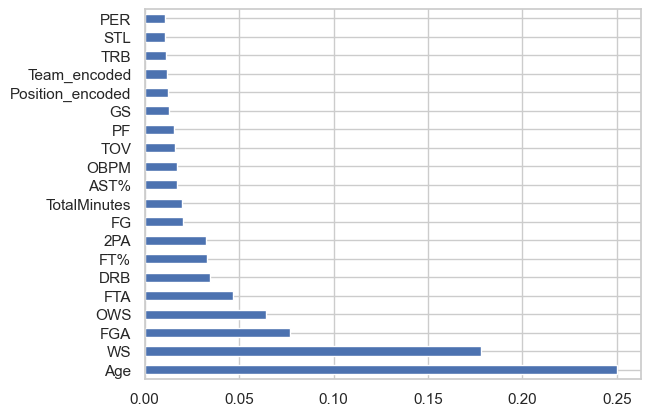

In [61]:
excluded_cols = ['Salary', 'Id', 'PlayerName', 'Salary_normalized']
feat_cols = list(set(nba_df.columns) - set(excluded_cols))
feat_importances = pd.Series(rf.feature_importances_, index=feat_cols)
feat_importances.nlargest(20).plot(kind='barh')